#   Melanoma skin cancer detection

Importing the required libraries 

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

connecting gdrive for the train and test data 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Specifying the root path

#### Defining the path for train and test images

In [3]:
root_path = 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/' 

In [4]:


data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

#### Counting the images for train and test  

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Create a dataset
Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.


In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, validation_split= 0.2, subset= 'training', image_size=(img_height,img_width), batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)
     

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data
Create a code to visualize one instance of all the nine classes present in the dataset

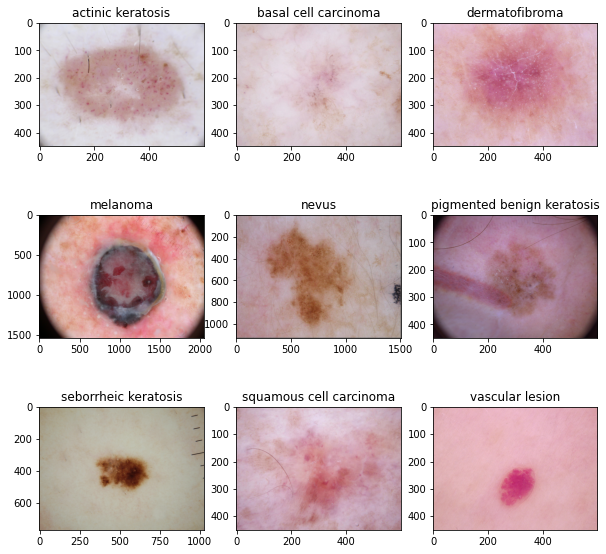

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

### your code goes here, you can use training or validation data to visualize

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model

 a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile the model

Choose an appropirate optimiser and loss function for model training

In [13]:

### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:

# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

## Trainning the model 


In [15]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 391s 2s/step - loss: 2.0559 - accuracy: 0.2093 - val_loss: 2.0225 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 71ms/step - loss: 2.0225 - accuracy: 0.2081 - val_loss: 1.9969 - val_accuracy: 0.2260
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: 1.8553 - accuracy: 0.3170 - val_loss: 1.6729 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6421 - accuracy: 0.4035 - val_loss: 1.5727 - val_accuracy: 0.4295
Epoch 5/20
56/56 [==============================] - 4s 70ms/step - loss: 1.5747 - accuracy: 0.4392 - val_loss: 1.5408 - val_accuracy: 0.4609
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.5011 - accuracy: 0.4671 - val_loss: 1.4389 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 4s 72ms/step - loss: 1.4451 - accuracy: 0.4766 - val_loss: 1.4894 - val_accuracy: 0.4877
Epoch 8/20
56/56 [======

Visualizing training results


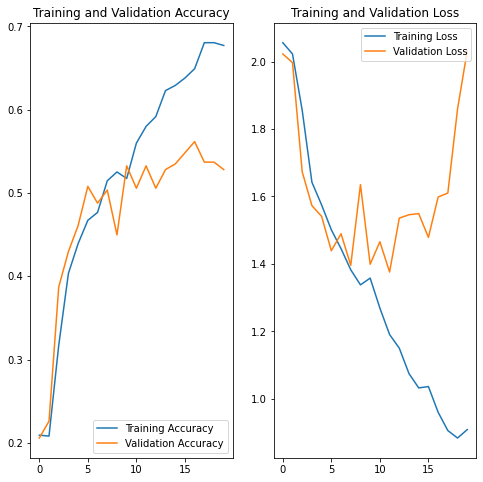

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

Finding on the first base model

The model is overfitting because we can also see difference in loss functions in training & test 

The accuracy is just around 60-70% because there are enough features to remember the pattern.

But again, it's too early to comment on the overfitting & underfitting 

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

from tensorflow import keras

data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

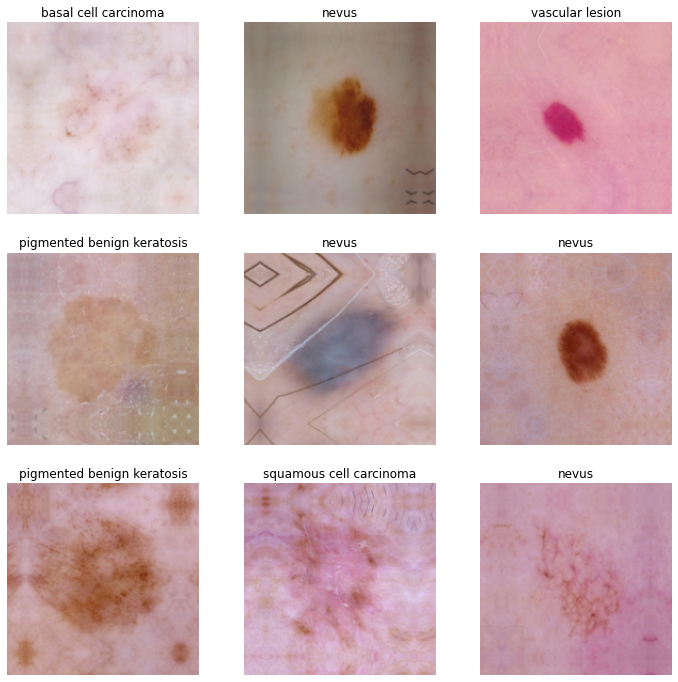

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
from tensorflow import keras

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Create the model, compile and train the model


In [19]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compile the model

In [20]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [21]:
from tensorflow import keras

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 81ms/step - loss: 2.0567 - accuracy: 0.1897 - val_loss: 2.0198 - val_accuracy: 0.2081
Epoch 2/20
56/56 [==============================] - 4s 73ms/step - loss: 1.9296 - accuracy: 0.2785 - val_loss: 1.7560 - val_accuracy: 0.4094
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.8269 - accuracy: 0.3387 - val_loss: 1.6719 - val_accuracy: 0.3848
Epoch 4/20
56/56 [==============================] - 4s 73ms/step - loss: 1.6052 - accuracy: 0.4152 - val_loss: 1.5774 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.5559 - accuracy: 0.4364 - val_loss: 1.5403 - val_accuracy: 0.4586
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.4557 - accuracy: 0.4944 - val_loss: 1.3811 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 4s 74ms/step - loss: 1.3541 - accuracy: 0.5296 - val_loss: 1.3897 - val_accuracy: 0.5324
Epoch 8/20
56

visualizing the result 

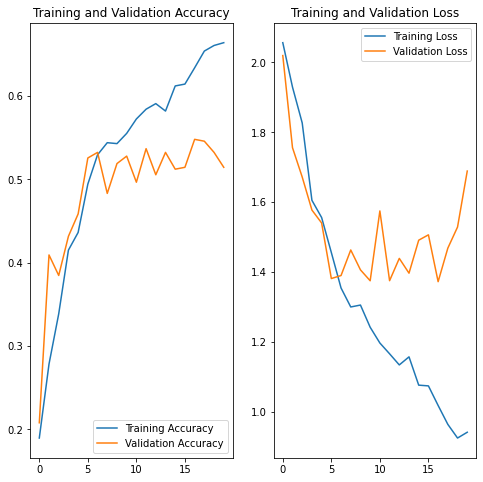

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

, Finding from Second Model

There is no improvement in accuracy, The accuracy is just around 60-70%

 But we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement

Todo: Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
##
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
1,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
2,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
3,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
4,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion
2235,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion
2236,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion
2237,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion


In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
1,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
2,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
3,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
4,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion
2235,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion
2236,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion
2237,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion


<BarContainer object of 9 artists>

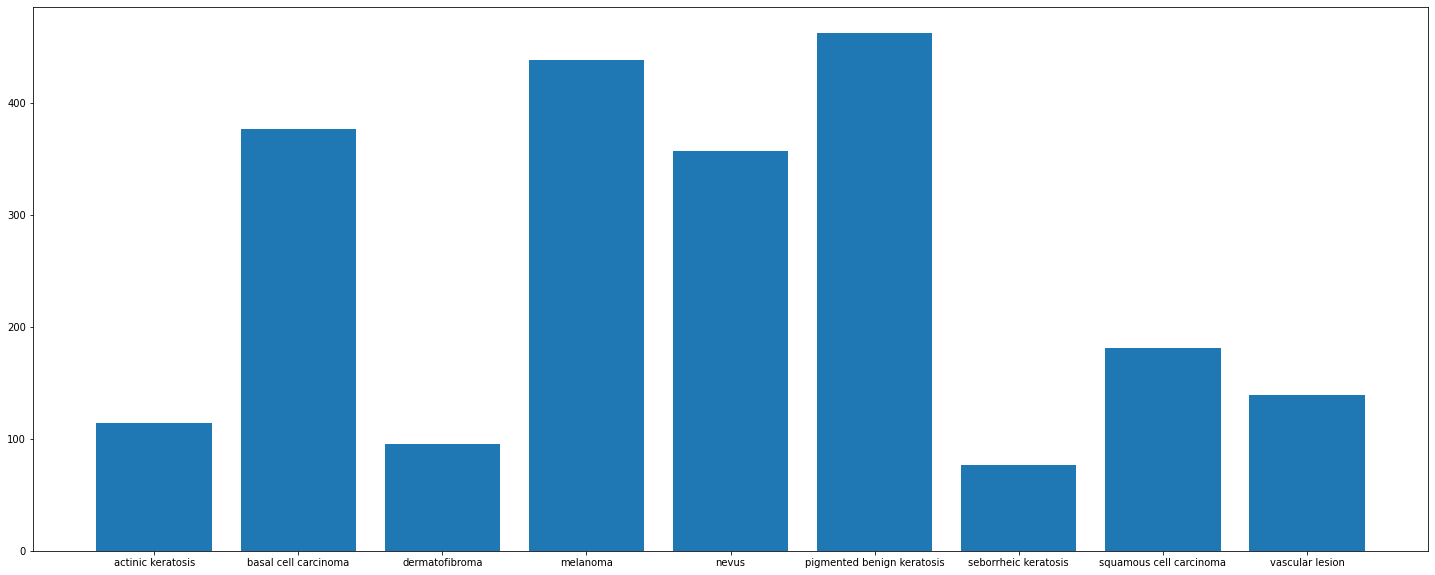

In [25]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

Todo: Write your findings here:
- Which class has the least number of samples?

Answer-1 :- seborrheic keratosis has least number of samples


- Which classes dominate the data in terms proportionate number of samples?



Answer-2:- melanoma and pigmented benign keratosis have proportionate number of classes. Next would be nevus and basal cell carcinoma  have propotionate number of classes

In [26]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Todo: Rectify the class imbalance

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

Data augmentation can improve training progress by amplifying differences in the dataset. This can be useful if the available dataset is small since, in this case, it is possible that a network could quickly learn every example in the dataset (overfitting), without augmentation

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:


Instantiate a Pipeline object pointing to a directory containing your initial image data set.

Define a number of operations to perform on this data set using your Pipeline object.

Execute these operations by calling the Pipeline’s sample() method.

In [28]:
path_to_training_dataset="/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset,output_directory='/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'+i+'/output/',save_format='jpg')
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1ABC185880>: 100%|██████████| 500/500 [00:57<00:00,  8.70 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1A30129400>: 100%|██████████| 500/500 [00:46<00:00, 10.72 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1A12DC89D0>: 100%|██████████| 500/500 [00:49<00:00, 10.02 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1A12B35E80>: 100%|██████████| 500/500 [00:50<00:00,  9.91 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F1A12FBE6A0>: 100%|██████████| 500/500 [00:51<00:00,  9.64 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=959x639 at 0x7F1A300471F0>: 100%|██████████| 500/500 [00:43<00:00, 11.40 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1A12A6DE20>: 100%|██████████| 500/500 [00:45<00:00, 11.02 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1A12A8E370>: 100%|██████████| 500/500 [00:47<00:00, 10.62 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1A12DC0940>: 100%|██████████| 500/500 [00:47<00:00, 10.58 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.






In [29]:
 data_dir_train1 = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


Lets see the distribution of augmented data after adding new images to the original training data.


In [30]:
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
1,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
2,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
3,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
4,/content/gdrive/My Drive/Skin cancer ISIC The ...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion
2235,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion
2236,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion
2237,/content/gdrive/My Drive/Skin cancer ISIC The ...,vascular lesion


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.



Lets see the distribution of augmented data after adding new images to the original training data.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

Creating training data set 

In [32]:
data_dir_train1=pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Creating validation dataset 

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Todo: Create your model (make sure to include normalization)


In [36]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


Todo: Compile your model (Choose optimizer and loss function appropriately)


In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
class_names1 = train_ds.class_names
print(class_names1)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Training the model 

In [40]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 41s 223ms/step - loss: 2.1832 - accuracy: 0.1350 - val_loss: 2.1891 - val_accuracy: 0.1440
Epoch 2/50
169/169 [==============================] - 37s 214ms/step - loss: 2.1797 - accuracy: 0.1434 - val_loss: 2.1911 - val_accuracy: 0.1403
Epoch 3/50
169/169 [==============================] - 40s 233ms/step - loss: 2.1721 - accuracy: 0.1571 - val_loss: 2.1781 - val_accuracy: 0.1604
Epoch 4/50
169/169 [==============================] - 40s 232ms/step - loss: 2.1630 - accuracy: 0.1656 - val_loss: 2.1788 - val_accuracy: 0.1574
Epoch 5/50
169/169 [==============================] - 40s 232ms/step - loss: 2.1548 - accuracy: 0.1860 - val_loss: 2.1765 - val_accuracy: 0.1633
Epoch 6/50
169/169 [==============================] - 40s 233ms/step - loss: 2.1420 - accuracy: 0.1877 - val_loss: 2.1766 - val_accuracy: 0.1611
Epoch 7/50
169/169 [==============================] - 40s 233ms/step - loss: 2.1233 - accuracy: 0.2044 - val_loss: 2.1756 - val_accuracy: 0.1

visualize the model 

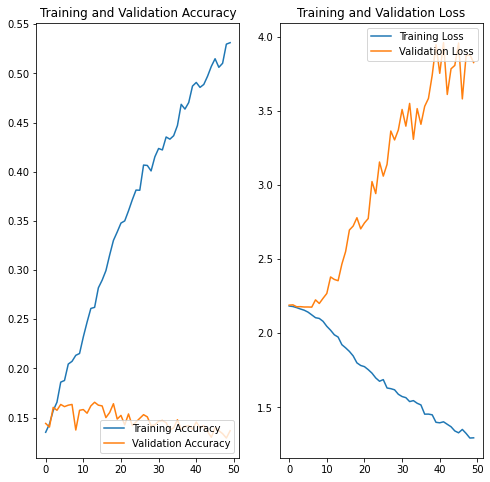

In [41]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy seems to be 45-55%  by using Augmentor library

Model is still overfitting

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

The Model can be further improved by tuning the hyperparameter